In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [27]:
# Generate the expected result from the tsv file.
expected = pd.read_csv('expected.tsv', sep='\t', index_col=0, names=['Organism', 'Counts'], header=0)
expected = expected[['Counts']].astype(int)

# Calculate expected relative abundance.
expected['RA'] = expected['Counts'] / expected['Counts'].sum()
expected.head(12)

,Counts,RA
Organism,,
Muricauda sp.,74263482,0.180311
Psychrobacter sp.,45769662,0.111128
Marinobacter sp. 8,64862842,0.157486
Marinobacter sp. 1,20090318,0.048779
Cohaesibacter sp.,29119402,0.070702
Halomonas sp. HL-4,71778728,0.174278
Halomonas sp. HL-93,80284678,0.194930
Thioclava sp.,12987850,0.031534
Propionibact. b.,4794346,0.011641


In [48]:
# Let's split the organism index into two columns to find the genera.
orgs = expected.index.to_list()
genus = [org.strip().split(' ')[0] for org in orgs]
genus = [x.replace('M.', 'Micromonospora') for x in genus]

# Add the columns to the dataframe.
expected['Genus'] = genus
display(expected.head(12))

# Group by genus and sum the counts for overlapping genera.
exp_genus = expected.groupby('Genus').sum()
exp_genus.sort_values('RA', ascending=False, inplace=True)
exp_genus

,Counts,RA,Genus
Organism,,,
Muricauda sp.,74263482,0.180311,Muricauda
Psychrobacter sp.,45769662,0.111128,Psychrobacter
Marinobacter sp. 8,64862842,0.157486,Marinobacter
Marinobacter sp. 1,20090318,0.048779,Marinobacter
Cohaesibacter sp.,29119402,0.070702,Cohaesibacter
Halomonas sp. HL-4,71778728,0.174278,Halomonas
Halomonas sp. HL-93,80284678,0.194930,Halomonas
Thioclava sp.,12987850,0.031534,Thioclava
Propionibact. b.,4794346,0.011641,Propionibact.


,Counts,RA
Genus,,
Halomonas,152063406,0.369208
Marinobacter,84953160,0.206265
Muricauda,74263482,0.180311
Psychrobacter,45769662,0.111128
Cohaesibacter,29119402,0.070702
Thioclava,12987850,0.031534
Micromonospora,7912204,0.019211
Propionibact.,4794346,0.011641


<AxesSubplot:title={'center':'Expected Relative Abundance'}, xlabel='Genus'>

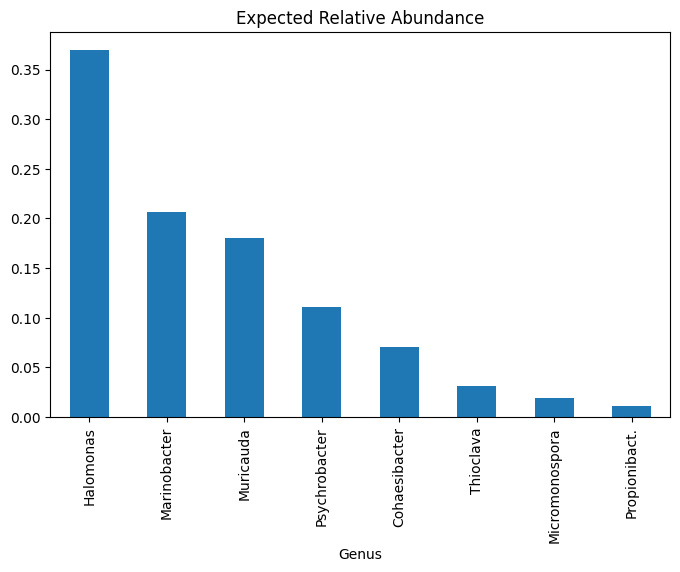

In [71]:
exp_genus.plot.bar(y='RA', figsize=(8, 5), legend=False, title='Expected Relative Abundance')

In [115]:
# Now, load in the experimental values.
r_genus = pd.read_csv('pipelines/woltka/genus_rel_abundance.csv', index_col=0, names=["Genus", "RA"], header=0)
# display(r_genus.head(12))
r_genus = r_genus[['RA']].astype(float)

# Merge on the genus key to compare results.
# merged = exp_genus.merge(r_genus, left_index=True, right_index=True)
# merged

# Instead, let's concat the two dataframes into long format and add a column from where it originated.
merged = pd.concat([exp_genus, r_genus], axis=0)

# !!! This is slick
merged['Source'] = ['Expected'] * len(exp_genus) + ['Observed'] * len(r_genus)
merged

,Counts,RA,Source
Genus,,,
Halomonas,152063406.0,3.692082e-01,Expected
Marinobacter,84953160.0,2.062653e-01,Expected
Muricauda,74263482.0,1.803109e-01,Expected
Psychrobacter,45769662.0,1.111282e-01,Expected
Cohaesibacter,29119402.0,7.070158e-02,Expected
...,...,...,...
Morococcus,NaN,7.210000e-09,Observed
Reichenbachiella,NaN,7.210000e-09,Observed
Suttonella,NaN,7.210000e-09,Observed


In [89]:
# Linear regression with scikit.
X = merged['RA_x'].values.reshape(-1, 1)
Y = merged['RA_y'].values.reshape(-1, 1)
reg = LinearRegression().fit(X, Y)
y_pred = reg.predict(X)
# reg.score(X, Y)

0.6969532134873464

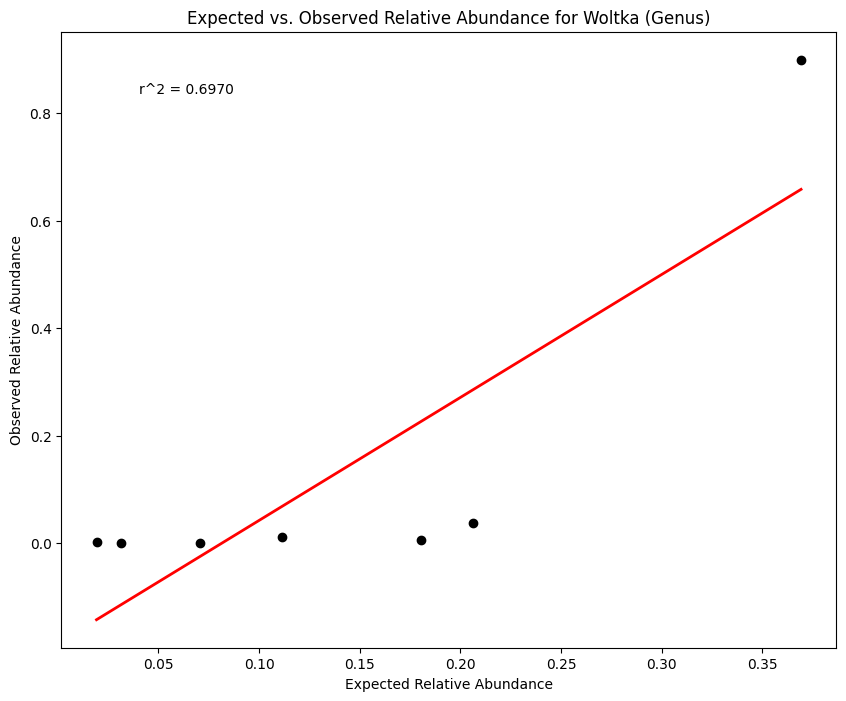

In [103]:
"""
fig = plt.figure(figsize=(10, 8))
# Scatter plot of RA_x vs. RA_y.
plt.scatter(merged['RA_x'], merged['RA_y'], color='black')
# plt.xlim(0, 1.0)
# plt.ylim(0, 1.0)
# Regression line.
plt.plot(X, y_pred, color='red', linewidth=2)
# Labels.
plt.xlabel('Expected Relative Abundance')
plt.ylabel('Observed Relative Abundance')
plt.title('Expected vs. Observed Relative Abundance for Woltka (Genus)')
# Add r^2 value.
plt.text(0.1, 0.9, f'r^2 = {reg.score(X,Y):.4f}', transform=plt.gca().transAxes)

plt.show()
"""

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

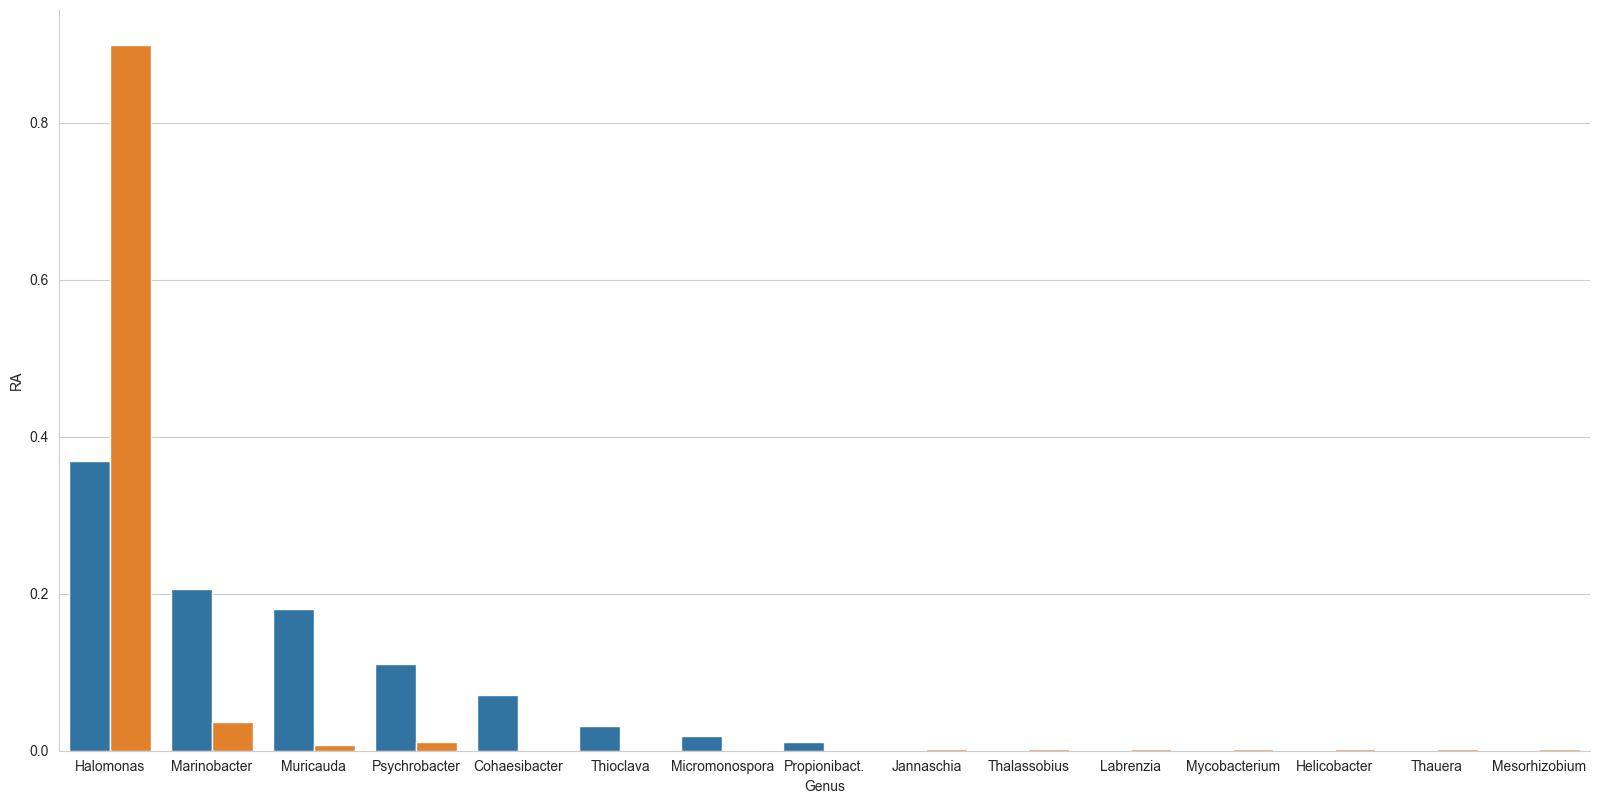

In [122]:
# Bar plot of RA_x vs. RA_y side by side.
sns.set_style("whitegrid")
subset = merged.head(20)
# subset
sns.catplot(x=subset.index, y='RA', data=subset, hue="Source", kind='bar', height=8, aspect=2)